In [49]:
%pip install torch torchvision matplotlib numpy pandas scikit-learn mlxtend

Note: you may need to restart the kernel to use updated packages.


In [50]:
import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

In [51]:
import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split

from mlxtend.plotting import heatmap

In [52]:
from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable

In [53]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

Using device: mps


# Parameters

In [54]:
learning_rate    = 0.003  ## Adam default   ## 0.001
batch_size       = 32
N_Epochs         = 30  ##27000

# Read the data

In [55]:
data_path = "MNISTdata/"


mnist_train = datasets.MNIST(data_path, train=True, download=True)

In [56]:
mnist_test = datasets.MNIST(data_path, train=False, download=True)

In [57]:
mnist_train_tr = datasets.MNIST(data_path, train=True, download=False,
                                            transform=transforms.Compose([
                                                transforms.ToTensor()
                                            ]))
mnist_test_tr  = datasets.MNIST(data_path, train=False, download=False,
                                            transform=transforms.Compose([
                                                transforms.ToTensor()
                                            ]))

# Create Data Loaders

In [58]:
mnist_test_tr.data.shape

torch.Size([10000, 28, 28])

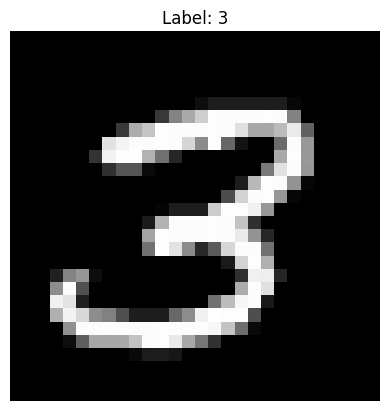

In [129]:
idx = random.randrange(len(mnist_train_tr))  # picks a random sample each run
img = mnist_train_tr.data[idx]
label = mnist_train_tr.targets[idx].item()

plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [59]:
train_dl  = torch.utils.data.DataLoader(mnist_train_tr, batch_size=batch_size, shuffle=True  )

test_dl   = torch.utils.data.DataLoader(mnist_test_tr,  batch_size=batch_size, shuffle=False )

# Utility Functions

In [60]:
def plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked):

    the_epochs = [i for i in range(len(list_losses_real))]

    plt.plot(the_epochs, list_losses_real,    label = "real")
    plt.plot(the_epochs, list_losses_fake,    label = "fake")
    plt.plot(the_epochs, list_losses_tricked, label = "tricked")
    plt.legend()
    plt.show()

In [61]:
def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat

In [62]:
def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = []
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)

    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [63]:
def random_G_vector_input(device=device):
    return torch.randn(100, device=device)

In [64]:
def random_G_batch_vector_input(device=device):
    return torch.randn((batch_size, 100), device=device)

In [65]:
# one hot encoding
# we are adding the classes for the context

def random_batch_one_hot_rc(batch_size, size, device=device):
    rand_vec = torch.zeros((batch_size, 10), device=device)
    for i in range(batch_size):
        random_idx = random.randint(0, size - 1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec

In [66]:
random_batch_one_hot_rc(32, 10)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


# NN Architectures

In [67]:
class Generator_Net(nn.Module):

    def __init__(self):
        super().__init__()


        self.linear1 = nn.Linear(100+10, 256) # CAREFUL -> +10 because the hot encoded vector
        self.act1    = nn.LeakyReLU(0.02)
        self.norm1   = nn.LayerNorm(256)
        self.linear2 = nn.Linear(256, 784)
        self.act2    = nn.Sigmoid()
        self.dropout = nn.Dropout(0.25)


    def forward(self, rand_input, label_tensor ):

        ## print(rand_input.shape)
        ## print(label_tensor.shape)

        inputs = torch.cat( ( rand_input , label_tensor) , dim=1)

        x      = self.linear1( inputs )
        x      = self.act1(x)
        x      = self.norm1(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        y_pred = x

        return y_pred

In [68]:
class Generator_DL_Net(nn.Module):

    def __init__(self):
        super().__init__()


        self.linear1 = nn.Linear(100+10, 60)
        self.act1    = nn.LeakyReLU(0.02)
        self.norm1   = nn.LayerNorm(60)
        self.linear2 = nn.Linear(60, 120)
        self.act2    = nn.LeakyReLU(0.02)
        self.norm2   = nn.LayerNorm(120)
        self.linear3 = nn.Linear(120, 784)
        self.act3    = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)


    def forward(self, rand_input ):

        inputs = torch.cat( ( rand_input , label_tensor) , dim=1)

        x      = self.linear1( inputs )
        x      = self.act1(x)
        x      = self.norm1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.norm2(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        x      = self.act3(x)

        y_pred = x

        return y_pred

In [69]:
class Discriminator_Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(784+10, 100) # we also need the context here
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(100, 50)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(50, 1)
        self.act3    = nn.Sigmoid()             ## nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)


    def forward(self, x, label_tensor):

        inputs = torch.cat( (x, label_tensor) , dim=1)

        x      = self.linear1( inputs )
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        y_pred = self.act3(x)

        return y_pred

# Training Function

In [70]:
list_losses_real    = []
list_losses_fake    = []
list_losses_tricked = []


def training_loop(N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt):

    G_model.to(device)
    D_model.to(device)

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:              ## xb = [batch, 1, 28, 28]

            xb = xb.to(device)
            yb = yb.to(device)

            xb = torch.squeeze(xb, dim=1)
            xb = xb.reshape((-1, 784))

            yb = F.one_hot(yb, num_classes=10).float().to(device)

            ###################### DISCRIMINATOR ###########################

            rand_vector = random_batch_one_hot_rc(batch_size, 10, device)

            gen_img = G_model(random_G_batch_vector_input(device), rand_vector).detach()

            ## Train D with real data
            D_real_y_pred = D_model(xb, yb)
            D_real_loss   = D_loss_fn(D_real_y_pred, torch.ones((batch_size, 1), device=device))
            D_opt.zero_grad()
            D_real_loss.backward()
            D_opt.step()

            ## Train D with fake data
            D_fake_y_pred = D_model(gen_img, rand_vector)
            D_fake_loss   = D_loss_fn(D_fake_y_pred, torch.zeros((batch_size, 1), device=device))
            D_opt.zero_grad()
            D_fake_loss.backward()
            D_opt.step()

            ######################### GENERATOR ########################

            rand_vector = random_batch_one_hot_rc(batch_size, 10, device)

            gen_img = G_model(random_G_batch_vector_input(device), rand_vector)

            ## Train G with D_loss (need to trick D)
            D_tricked_y_pred = D_model(gen_img, rand_vector)
            D_tricked_loss   = D_loss_fn(D_tricked_y_pred, torch.ones((batch_size, 1), device=device))
            G_opt.zero_grad()
            D_tricked_loss.backward()
            G_opt.step()

        if epoch % 1 == 0:
            print("******************************")
            print(epoch, "D_real_loss=", D_real_loss)
            print(epoch, "D_fake_loss=", D_fake_loss)
            print(epoch, "D_tricked_loss=", D_tricked_loss)
            list_losses_real.append(D_real_loss.detach().cpu().numpy())
            list_losses_fake.append(D_fake_loss.detach().cpu().numpy())
            list_losses_tricked.append(D_tricked_loss.detach().cpu().numpy())

In [71]:
G_model     = Generator_Net().to(device)

## G_model     = Generator_DL_Net()

D_model     = Discriminator_Net().to(device)

## D_loss_fn   = nn.CrossEntropyLoss( )
## D_loss_fn   = F.mse_loss

D_loss_fn   = nn.BCELoss()

G_opt       = torch.optim.Adam(G_model.parameters(), lr=learning_rate)
D_opt       = torch.optim.Adam(D_model.parameters(), lr=learning_rate)

training_loop(N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt)

******************************
0 D_real_loss= tensor(0.0448, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)
0 D_fake_loss= tensor(0.0279, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)
0 D_tricked_loss= tensor(11.4785, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)
******************************
1 D_real_loss= tensor(0.0466, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)
1 D_fake_loss= tensor(0.0152, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)
1 D_tricked_loss= tensor(9.6444, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)
******************************
2 D_real_loss= tensor(0.0793, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)
2 D_fake_loss= tensor(0.0301, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)
2 D_tricked_loss= tensor(5.8395, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)
******************************
3 D_real_loss= tensor(0.3886, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)
3 D_fake_loss= t

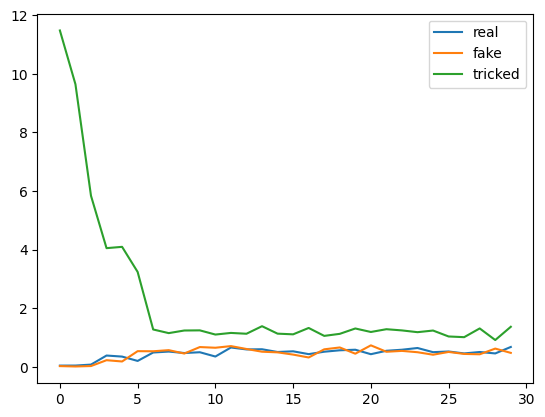

In [72]:
plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked)

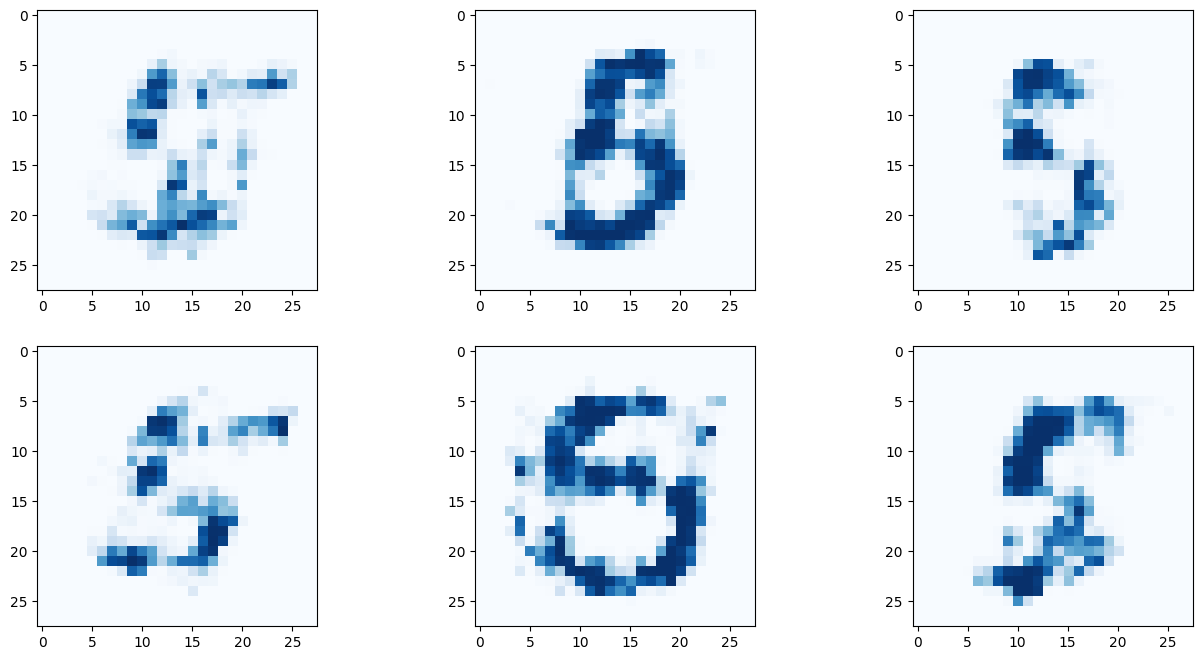

In [120]:
label = 5

label_tensor = torch.zeros((10), device=device)
label_tensor[label] = 1.0

label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2, 3, figsize=(16, 8))

for i in range(2):
    for j in range(3):
        output = G_model.forward(random_G_vector_input(device).unsqueeze(0), label_tensor)
        img = output.detach().cpu().numpy().reshape(28, 28)
        axarr[i, j].imshow(img, interpolation='none', cmap='Blues')